<a href="https://colab.research.google.com/github/AshnakAGQ/DistractedDriver/blob/master/CS175Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

##Tensorflow

In [13]:
!pip install tf-nightly
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt

In [0]:
print(tf.__version__)

2.3.0-dev20200610


##Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


##Kaggle

In [4]:
!pip install kaggle
import os # Sets the environment variables in the root folder 
os.environ['KAGGLE_USERNAME'] = "unorna"
os.environ['KAGGLE_KEY'] = "0a21e3dad74e374d7054ac533a76ede3"
import kaggle
kaggle.api.authenticate()
kaggle.api.competition_download_files('state-farm-distracted-driver-detection', path = 'data/DistractedDriver')
!unzip -q data/DistractedDriver/state-farm-distracted-driver-detection.zip  #unzips kaggle data into content/data

#Import image data


In [5]:
image_size = (224, 224) #image size for image net is 224 x 224 x 3
batch_size = 32

full_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "imgs/train",
    image_size = image_size,
    batch_size = batch_size,
    shuffle = False
)

full_ds_s = tf.keras.preprocessing.image_dataset_from_directory(
    "imgs/train",
    seed = 1337,
    image_size = image_size,
    batch_size = batch_size,
    shuffle = True
)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "imgs/train",
    seed = 1337,
    image_size = image_size,
    batch_size = batch_size,
    subset = 'training',
    validation_split = 0.2,
    shuffle = True
).prefetch(tf.data.experimental.AUTOTUNE)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "imgs/train",
    seed = 1337,
    image_size = image_size,
    batch_size = batch_size,
    subset = 'validation',
    validation_split = 0.2,
    shuffle = True
).prefetch(tf.data.experimental.AUTOTUNE)

Found 22424 files belonging to 10 classes.
Found 22424 files belonging to 10 classes.
Found 22424 files belonging to 10 classes.
Using 17940 files for training.
Found 22424 files belonging to 10 classes.
Using 4484 files for validation.


##View Data

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in full_ds_s.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

#Cross-Validation

In [0]:
def crossvalidate(dataset, n_splits, batch_size=32, seed=0):

  """
  Given a dataset, splits it into {n_splits} subsets, where for 
  any given index, train_ds[i] contains all the subsets except 
  the portion in val_ds[i]

  Parameters
  ----------
  dataset : tensorflow.data.dataset
      Full dataset to split
    
  n_splits : int
      Number of splits; XFold # (at least 2 or greater)
      
  Returns
  -------
  train_ds : list (dtype=ConcatenateDataset)
      List of datasets not containing the ith portion of data
      
  val_ds : list (dtype=ShardDataset)
      List of datasets containing the ith portion of data
  
  """

  # Initialize lists
  val_ds = []
  train_ds = []

  # Create val_ds first
  for i in range(n_splits):
    val_ds.append(dataset.shard(num_shards=n_splits, index=i).shuffle(buffer_size=batch_size * 8, seed=seed))

  # Create train_ds using val_ds indexes other than the current index
  for i in range(n_splits):
    if i == 0:
      train_ds.append(val_ds[1])
    else:
      train_ds.append(val_ds[0])
    for a in range(1, i):
      train_ds[i] = train_ds[i].concatenate(val_ds[a].shuffle(buffer_size=batch_size * 8, seed=seed))
    for b in range(i+1, n_splits):
      if not(i==0 and b==1):
        train_ds[i] = train_ds[i].concatenate(val_ds[b].shuffle(buffer_size=batch_size * 8, seed=seed))

  return train_ds, val_ds

In [0]:
n_splits = 5

cv_training_ds, cv_val_ds = crossvalidate(full_ds, n_splits, seed=1337)

"""# Set up prefetching
for i in range(len(cv_training_ds)):m
  cv_training_ds[i] = cv_training_ds[i].prefetch(tf.data.experimental.AUTOTUNE)
  cv_val_ds[i] = cv_val_ds[i].prefetch(tf.data.experimental.AUTOTUNE)
"""
print(len(cv_training_ds), cv_training_ds[0])
print(len(cv_val_ds), cv_val_ds[0])

print(tf.data.experimental.cardinality(full_ds))
print(tf.data.experimental.cardinality(cv_training_ds[1]))
print(tf.data.experimental.cardinality(train_ds))
print(tf.data.experimental.cardinality(cv_val_ds[1]))
print(tf.data.experimental.cardinality(validation_ds))

In [0]:
"""import time
def benchmark(dataset, num_epochs=2):
    start_time = time.perf_counter()

    model = VGG16(include_top=False,weights='imagenet', input_shape=(320,240,3))
    flatten = Flatten()(model.outputs[-1])
    output = Dense(10, activation = 'softmax')(flatten)
    model = Model(inputs=model.inputs,outputs=output)

    # Might have to copy data from Google Drive to the Google Environment
    model.compile(optimizer='adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
    model.fit(dataset, epochs=10)

    # Generate generalization metrics
    scores = model.evaluate(dataset, verbose=0)
    
    tf.print("Execution time:", time.perf_counter() - start_time)"""

In [0]:
import numpy as np

for images, labels in full_ds_s.take(1):
  print(images)

In [0]:
# batch size = 32
#benchmark(cv_val_ds[0])

In [0]:
# batch size = 32
#benchmark(cv_val_ds[0].prefetch(tf.data.experimental.AUTOTUNE))

In [0]:
# batch size = 128
#benchmark(cv_val_ds[0].prefetch(tf.data.experimental.AUTOTUNE))

#Model Testing

In [0]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode ='min', patience=4),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5', save_best_only=True)
]
inception_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode ='min', patience=4),
    tf.keras.callbacks.ModelCheckpoint(filepath='inceptionmodel.{epoch:02d}-{val_loss:.2f}.h5', save_best_only=True)
]

resnet_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='loss',mode ='auto', patience=4),
    tf.keras.callbacks.ModelCheckpoint(filepath='resnet.{epoch:02d}-{loss:.2f}.h5', save_best_only=True)

]

##VGG16

###Summary

In [0]:
model = VGG16(include_top=True, weights = None, classes = 10, input_shape=(224, 224, 3))
#model = VGG16(include_top=False,weights='imagenet', input_shape=(224,224,3))
#flatten = Flatten()(model.outputs[-1])
#output = Dense(10, activation = 'softmax')(flatten)
#model = Model(inputs=model.inputs,outputs=output)
model.summary()

In [0]:
# model.save_weights('drive/My Drive/my_model_weights.h5') # Save the current model into Google Drive

###Testing

In [0]:
def VGG_preprocess(image,score):
  image = keras.applications.vgg16.preprocess_input(image)
  if score is None:
        return image
  else:
        return image, score

accuracies = []
losses = []

for i in range(len(cv_training_ds)):

  # Pre-processing
  train = cv_training_ds[i].map(VGG_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  train = train.prefetch(tf.data.experimental.AUTOTUNE)
  val = cv_val_ds[i].map(VGG_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  val = val.prefetch(tf.data.experimental.AUTOTUNE)

  model = VGG16(include_top=True, weights = None, classes = 10, input_shape=(224, 224, 3))
  #model = VGG16(include_top=False, classes = 10, input_shape=(320,240,3))
  #flatten = Flatten()(model.outputs[-1])
  #output = Dense(10, activation = 'softmax')(flatten)
  #model = Model(inputs=model.inputs,outputs=output)

  # Might have to copy data from Google Drive to the Google Environment
  model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
  model.fit(train, epochs=10, validation_data=val, callbacks=my_callbacks)

  # Generate generalization metrics
  scores = model.evaluate(val, verbose=0)
  accuracies.append(scores[1] * 100)
  losses.append(scores[0])

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(accuracies)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {losses[i]} - Accuracy: {accuracies[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(accuracies)} (+- {np.std(accuracies)})')
print(f'> Loss: {np.mean(losses)}')
print('------------------------------------------------------------------------')

##Resnet

###Summary

In [0]:
resnet_model = ResNet50(include_top =True,weights='imagenet', input_shape=(224,224,3))
resnet_output= Flatten()(resnet_model.outputs[-1])
# resnet_output = Dense(10, activation = 'softmax')(resnet_flatten)
resnet_model = Model(inputs=resnet_model.inputs,outputs=resnet_output)
# for layers in resnet_model.layers:
#   layers.trainable = False
resnet_edited = tf.keras.Sequential()
resnet_edited.add(resnet_model)
resnet_edited.add(Dense(4096, activation='relu'))
resnet_edited.add(tf.keras.layers.Dropout(0.3))
resnet_edited.add(Dense(4096, activation='relu'))
resnet_edited.add(tf.keras.layers.Dropout(0.3))
resnet_edited.add(Dense(10, activation='softmax'))
# resnet_edited.summary()
# resnet_model.summary()

###Testing

In [0]:
accuracies = []
losses = []

for i in range(len(cv_training_ds)):
  resnet_model = ResNet50(include_top =False,weights='imagenet', input_shape=(320,240,3))
  resnet_flatten = Flatten()(resnet_model.outputs[-1])
  resnet_output = Dense(10, activation = 'softmax')(resnet_flatten)
  resnet_model = Model(inputs=resnet_model.inputs,outputs=resnet_output)
  
  resnet_model.compile(optimizer='nadam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
  resnet_model.fit(cv_training_ds[i], epochs=10, validation_data=cv_val_ds[i], callbacks=my_callbacks)

  # Generate generalization metrics
  scores = resnet_model.evaluate(cv_val_ds[i], verbose=0)
  accuracies.append(scores[1] * 100)
  losses.append(scores[0])

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(accuracies)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {losses[i]} - Accuracy: {accuracies[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(accuracies)} (+- {np.std(accuracies)})')
print(f'> Loss: {np.mean(losses)}')
print('------------------------------------------------------------------------')

In [10]:
def Resnet_preprocess(image,score):
  image = keras.applications.resnet50.preprocess_input(image)
  if score is None:
        return image
  else:
        return image, score
train = full_ds_s.map(Resnet_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train = train.prefetch(tf.data.experimental.AUTOTUNE)

resnet_edited.compile(optimizer='adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
history = resnet_edited.fit(train, epochs=10)


Epoch 1/10
701/701 [==============================] - 129s 184ms/step - loss: 2.2970 - accuracy: 0.1090
Epoch 2/10
701/701 [==============================] - 129s 183ms/step - loss: 2.2473 - accuracy: 0.1381
Epoch 3/10
701/701 [==============================] - 128s 183ms/step - loss: 2.1428 - accuracy: 0.1729
Epoch 4/10
701/701 [==============================] - 128s 183ms/step - loss: 2.0317 - accuracy: 0.2269
Epoch 5/10
701/701 [==============================] - 129s 184ms/step - loss: 1.5822 - accuracy: 0.3947
Epoch 6/10
701/701 [==============================] - 128s 183ms/step - loss: 0.7355 - accuracy: 0.7379
Epoch 7/10
701/701 [==============================] - 129s 183ms/step - loss: 0.2955 - accuracy: 0.9124
Epoch 8/10
701/701 [==============================] - 128s 183ms/step - loss: 0.1564 - accuracy: 0.9582
Epoch 9/10
701/701 [==============================] - 128s 183ms/step - loss: 0.1796 - accuracy: 0.9522
Epoch 10/10
701/701 [==============================] - 129s 184m

In [12]:
history.history

{'accuracy': [0.109034962952137,
  0.1380663514137268,
  0.17289511859416962,
  0.22694434225559235,
  0.3946664333343506,
  0.7379147410392761,
  0.9123706817626953,
  0.9581698179244995,
  0.952194094657898,
  0.9741794466972351],
 'loss': [2.296982765197754,
  2.2473411560058594,
  2.1428446769714355,
  2.0316994190216064,
  1.5821892023086548,
  0.7355113625526428,
  0.2955186069011688,
  0.15644803643226624,
  0.17955373227596283,
  0.09818514436483383]}

Text(0, 0.5, 'Accuracy')

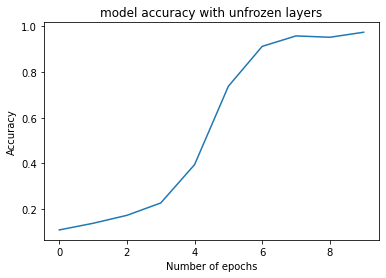

In [21]:
plt.plot(history.history['accuracy'])
plt.title("model accuracy with unfrozen layers")
plt.xlabel('Number of epochs')
plt.ylabel("Accuracy")

Text(0, 0.5, 'Loss')

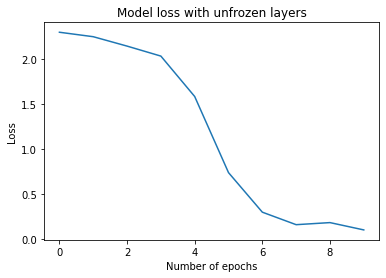

In [22]:
plt.plot(history.history['loss'])
plt.title("Model loss with unfrozen layers")
plt.xlabel('Number of epochs')
plt.ylabel("Loss")

##Inception

###Summary

In [0]:
inception_model = InceptionV3(include_top =False,weights='imagenet', input_shape=(320,240,3))
inception_flatten = Flatten()(inception_model.outputs[-1])
inception_output = Dense(10, activation = 'softmax')(inception_flatten)
inception_model = Model(inputs=inception_model.inputs,outputs=inception_output)
inception_model.summary()

###Testing

In [0]:
accuracies = []
losses = []

for i in range(len(cv_training_ds)):
  inception_model = InceptionV3(include_top =False,weights='imagenet', input_shape=(320,240,3))
  inception_flatten = Flatten()(inception_model.outputs[-1])
  inception_output = Dense(10, activation = 'softmax')(inception_flatten)
  inception_model = Model(inputs=inception_model.inputs,outputs=inception_output)

  inception_model.compile(optimizer='nadam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
  inception_model.fit(cv_training_ds[i], epochs=10, validation_data=cv_val_ds[i], callbacks=inception_callbacks)

  # Generate generalization metrics
  scores = inception_model.evaluate(cv_val_ds[i], verbose=0)
  accuracies.append(scores[1] * 100)
  losses.append(scores[0])

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(accuracies)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {losses[i]} - Accuracy: {accuracies[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(accuracies)} (+- {np.std(accuracies)})')
print(f'> Loss: {np.mean(losses)}')
print('------------------------------------------------------------------------')

In [0]:
#inception_model.save("drive/My Drive/inceptionv3_model.h5")

#Other

In [0]:
# it = iter(full_ds) # Dataset iterable
# images = next(it)[0].numpy() # Get first batch of images
# images = preprocess_input(images) # Preprocess images. Not sure if this necessary or not

# yhat = model.predict(images)